# Budget Testing

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

## Consistency check: Are the reconstructed dzt values good enough?
All simulations have the 'dzt' averages saved in the `ocean_budget` files. But for CM2.6 this would mean staging another 7TB.
So here I will test if the 'reconstruction' using SSH is sufficiently accurate

In [88]:
from mom_read import open_mom5_CM_ESM
from mom_budgets import calculate_dzstar, calculate_dz
from xarrayutils.utils import concat_dim_da

runnames = ['control']
years = range(181,201)
rho = 1035 # Constant reference density

In [89]:
cm21_varlist =['ocean', 'ocean_budgets'] # This is a bit different in CM2.6...lets unify this..., #'ocean_trans', 'ocean_budgets', 
cm21_gridfile = '/work/Julius.Busecke/CM2.1/siena_201303_fix_rds/static/grid_complete.nc'

ddir_cm21_control = '/work/Julius.Busecke/CM2.1/siena_201303_fix_rds/CM_O1p0_C180_A02-topaz-bling-minibling-ctrl-restart_bgc/pp'

ds = open_mom5_CM_ESM(ddir_cm21_control, varfolderlist=cm21_varlist, gridfile=cm21_gridfile, years=years)

reading ocean
None
adding offset of 2000 to time
decode_times: False
timesteps: 240
reading ocean_budgets
None
adding offset of 2000 to time
decode_times: False
timesteps: 240


In [90]:
ds.coords['dztstar'] = calculate_dzstar(ds, 'st')

<xarray.Dataset>
Dimensions:                 (nv: 2, st_edges_ocean: 51, st_ocean: 50, sw_edges_ocean: 51, sw_ocean: 50, time: 240, xt_ocean: 360, xu_ocean: 360, yt_ocean: 200, yu_ocean: 200)
Coordinates:
  * yt_ocean                (yt_ocean) float64 -81.5 -80.5 -79.5 ... 88.5 89.5
  * yu_ocean                (yu_ocean) float64 -81.0 -80.0 -79.0 ... 89.0 90.0
  * xt_ocean                (xt_ocean) float64 -279.5 -278.5 ... 78.5 79.5
  * nv                      (nv) float64 1.0 2.0
  * xu_ocean                (xu_ocean) float64 -279.0 -278.0 ... 79.0 80.0
  * st_ocean                (st_ocean) float64 5.034 15.1 ... 5.395e+03
  * st_edges_ocean          (st_edges_ocean) float64 0.0 10.07 ... 5.5e+03
  * sw_ocean                (sw_ocean) float64 10.07 20.16 ... 5.29e+03 5.5e+03
  * sw_edges_ocean          (sw_edges_ocean) float64 5.034 15.1 ... 5.5e+03
    geolon_t                (yt_ocean, xt_ocean) float64 dask.array<shape=(200, 360), chunksize=(200, 360)>
    geolat_t               

In [91]:
# so there is a problem with the bottom cells
# lets mask out the last tracer value at the bottom
bottom_idx = (~xr.ufuncs.isnan(ds.temp)).sum('st_ocean') -1
bottom_idx

dummy_depth = xr.DataArray(np.arange(len(ds.st_ocean)), dims=['st_ocean'])
dummy_count = ((ds.temp.fillna(0) * 0) + 1) * dummy_depth
mask = dummy_count >= bottom_idx

In [92]:
dzt_reconstructed = calculate_dz(ds.eta_t, ds.ht, ds.dztstar)
dzt_reconstructed_masked = dzt_reconstructed.where(~mask)
dzt_true = ds.rho_dzt / rho

In [93]:
# Calculate the relative error 
abs_error = dzt_reconstructed_masked - dzt_true
rel_error = abs_error / dzt_true

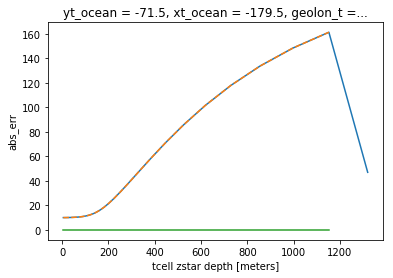

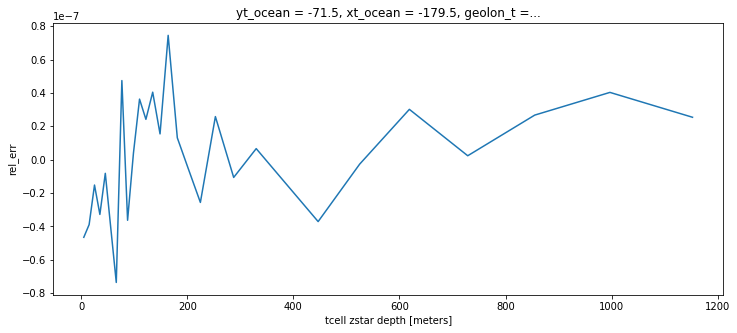

In [94]:
# Single example
roi = dict(time=3, xt_ocean=100, yt_ocean=10)
sample = xr.Dataset({'recon': dzt_reconstructed_masked, 'true': dzt_true, 'abs_err': abs_error, 'rel_err': rel_error,})
sample = sample.isel(**roi).load()
# idx = bottom_idx.isel(**roi).load()
# sample['recon'][{'st_ocean':slice(idx.data,None)}] = np.nan
# print(idx)

sample['true'].plot()
sample['recon'].plot(linestyle='--')
sample['abs_err'].plot()


plt.figure(figsize=[12,5])
sample['rel_err'].plot()

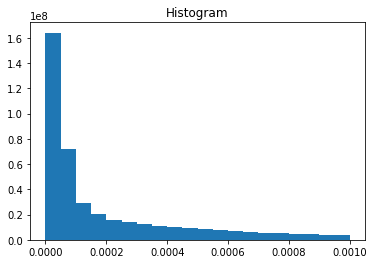

In [95]:
abs(abs_error*100).plot(bins=np.linspace(0, 1e-3, 21));

In [96]:
(abs_error*100).max().load()

<xarray.DataArray ()>
array(0.001517)

## Summary
- The reconstruction does not take into account the partial cell at the bottom
- The error is exceedingly small. 2/1000 of a percent at max

## Checking the dzu reconstruction

[[47.40450067 47.40486825]
 [47.40500328 47.40544141]]
47.404500669758846
47.404500669758846


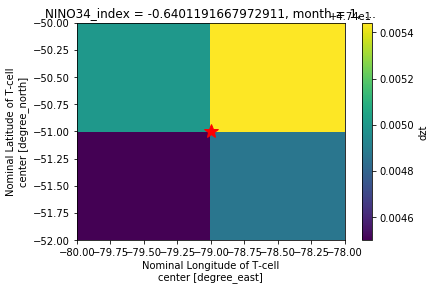

In [3]:
from mom_budgets import add_vertical_spacing
ds_test = xr.open_zarr('/work/Julius.Busecke/zarr_test/CM21deg_control.zarr')
ds_test = add_vertical_spacing(ds_test)

# Confirming that the dzu is the min of the sourrounding 4 dzt values
dzt = ds_test.dzt.isel(time=0, st_ocean=20, xt_ocean=slice(200, 202), yt_ocean=slice(30, 32))
dzu = ds_test.dzu.isel(time=0, st_ocean=20, xu_ocean=200, yu_ocean=30)
print(dzt.load().data)
print(dzt.min().load().data)
print(dzu.load().data)
dzt.plot()
plt.plot(dzu.xu_ocean, dzu.yu_ocean, marker='*',markersize=15, color='r')

## Test the advective tendency split
- There are some problems at the bottom cells (prob caused by the faulty computation of partial cells...need to fix that upstream)
- The results are not perfect, because I cannot represent the advection operator exactly and I am reconstructing from monthly averages...
- Overall though, I would say this looks quite all right, Id have to check the actual mass transports. These are only affected by the latter.

In [ ]:
def add_split_tendencies(ds):
    """Reconstructs various fluxes and tendencies (x-y_x) from the monthly averaged output. Hardcoded to o2 atm."""
    ds = ds.copy()
    rho = 1035 #reference density
    grid = Grid(ds)
    
    # Calculate thickness weighted mass transports from velocities according to MOM5 formulation
    uhrho_et, vhrho_nt, wrhot = reconstruct_hrho_trans(ds.u, ds.v, ds.wt, ds.dzt * rho, ds.dzu * rho, grid, rho)
    
    # Reconstruct the flux terms
    ds['o2_xflux_adv_recon'], ds['o2_yflux_adv_recon'], ds['o2_zflux_adv_recon'] = \
        approximate_transport_op(uhrho_et, vhrho_nt, wrhot, ds['o2'], grid, boundary='extend')
    
    # Reconstruct flux terms seperately for 
    
    
    # Calculate tendencies from all advective fluxes
    for suffix in ['', '_recon', 'recon_tracer', 'recon_vel']:
        ds['o2_advection_x'+suffix], \
        ds['o2_advection_y'+suffix], \
        ds['o2_advection_z'+suffix] = tend_from_fluxes(ds['o2_xflux_adv'+suffix],
                                                       ds['o2_yflux_adv'+suffix],
                                                       ds['o2_zflux_adv'+suffix], grid)
    
    

#     # some interpolations... might want to remap these in the future, to get more accurate estimates
#     u = grid.interp(ds['u'], 'Y')
#     v = grid.interp(ds['v'], 'X')
#     wt = ds['wt']
# #     dxte = grid.interp(ds.dxu, 'Y')
# #     dytn = grid.interp(ds.dyu, 'X')
    
    

#     # o2_flux reconstructed from tracer and velocity field (vel*tracer*dyt*dzt*rho)
#     # Are the values actually interpolated or do they take the center tracer value? Read up in MOM5 manual and correct if needed.
#     # This will need some more advanced testing...in the end we cannot really reproduce the complex advection scheme, but it is worth trying
# #     # to get as close as possible.
# #     ds['o2_xflux_adv_recon'] = grid.interp(ds['o2'], 'X') * u * ds.dzt * ds.dyte * rho
# #     ds['o2_yflux_adv_recon'] = grid.interp(ds['o2'], 'Y') * v * ds.dzt * ds.dxtn * rho
# #     ds['o2_zflux_adv_recon'] = grid.interp(ds['o2'], 'Z') * wt * ds.dxt * ds.dyt * rho

#     # Reconstruct the advective tendencies (as (tracer* s^-1) * dzt * rho)
#     # also not sure about the numerics here...this implements finite difference approach...which mom used for some variables but not all...

#     ds['o2_advection_x_recon_full'] = - (grid.diff(ds['o2_xflux_adv_recon'], 'X') / ds.area_t)
#     ds['o2_advection_x_recon_du'] = - (ds['o2'] * grid.diff(u, 'X') / ds.dxt * ds.dzt * rho)
#     ds['o2_advection_x_recon_do2'] = - (u * grid.diff(ds['o2'], 'X') / dxte * ds.dzt * rho)

#     ds['o2_advection_y_recon_full'] = - (grid.diff(ds['o2_yflux_adv_recon'], 'Y') / ds.area_t)
#     ds['o2_advection_y_recon_dv'] = - (ds['o2'] * grid.diff(v, 'Y') / ds.dyt * ds.dzt * rho)
#     ds['o2_advection_y_recon_do2'] = - (v * grid.diff(ds['o2'], 'Y') / dytn * ds.dzt * rho)

#     ds['o2_advection_z_recon_full'] =  (grid.diff(ds['o2_zflux_adv_recon'], 'Z') / ds.area_t)
#     ds['o2_advection_z_recon_dwt'] =  (ds['o2'] * grid.diff(wt, 'Z') * rho)
#     ds['o2_advection_z_recon_do2'] =  (wt * grid.diff(ds['o2'], 'Z') * rho)
    return ds

In [61]:
%load_ext autoreload
%autoreload 1
%aimport mom_budgets
from mom_budgets import add_vertical_spacing, add_split_tendencies
ds_test = xr.open_zarr('/work/Julius.Busecke/zarr_test/CM21deg_control.zarr')
ds_test = add_vertical_spacing(ds_test)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
ds_test = add_split_tendencies(ds_test)

Vertical spacing for vertical vel cell is approximated!!! Use with caution
Spacing for `dxte` is approximated!!! Use with caution
Spacing for `dytn` is approximated!!! Use with caution


/home/Julius.Busecke/code/miniconda/envs/standard/lib/python3.6/site-packages/dask/core.py:137: RuntimeWarning: divide by zero encountered in true_divide
  return func(*args2)


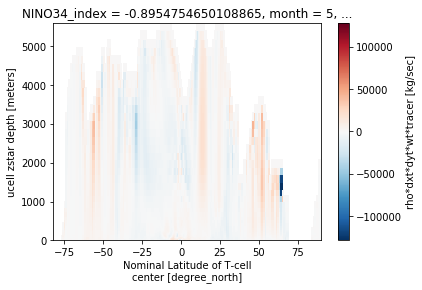

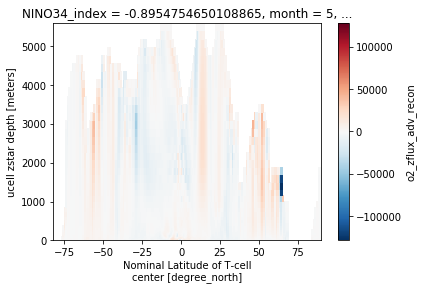

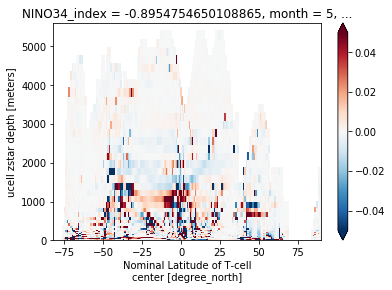

In [37]:
roi = dict(time=4, xu_ocean=250)
fld = 'o2_xflux_adv'

roi = dict(time=4, xt_ocean=250)
fld = 'o2_yflux_adv'

roi = dict(time=4, xt_ocean=250)
fld = 'o2_zflux_adv'

plt.figure()
ds_test['%s' %fld].isel(**roi).plot()

plt.figure()
ds_test['%s_recon' %fld].isel(**roi).plot()

plt.figure()
((ds_test['%s_recon' %fld] - ds_test['%s' %fld]) / ds_test['%s' %fld]).isel(**roi).plot(vmax=0.05)

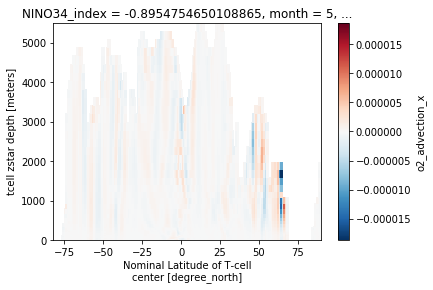

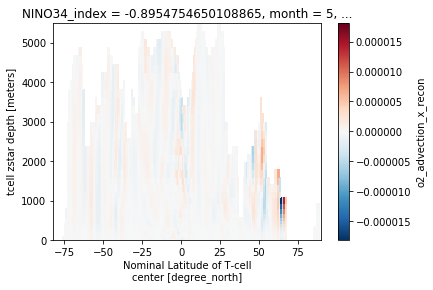

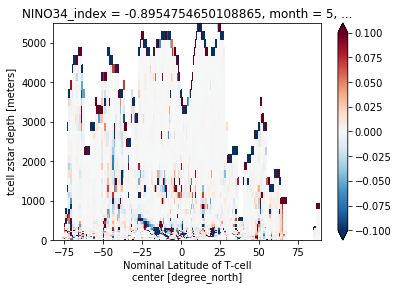

In [52]:
# Test if the decomposition works
plt.figure()
ds_test['o2_advection_x'].isel(**roi).plot()


plt.figure()
ds_test['o2_advection_x_recon'].isel(**roi).plot()


plt.figure()
((ds_test['o2_advection_x_recon'] - ds_test['o2_advection_x']) / ds_test['o2_advection_x']).isel(**roi).plot(vmax=0.1)

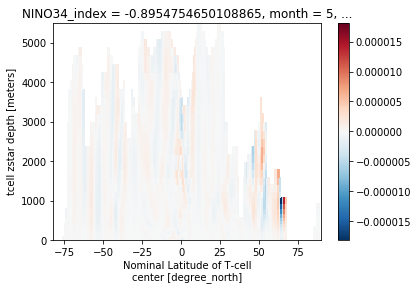

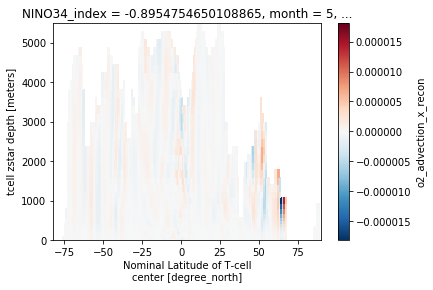

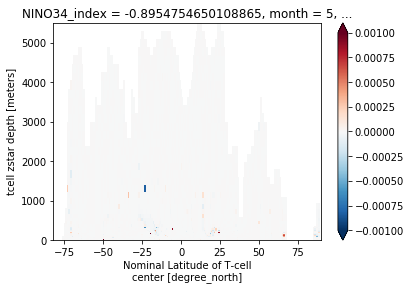

In [60]:
plt.figure()
(ds_test['o2_advection_x_recon_vel'] + ds_test['o2_advection_x_recon_tracer']).isel(**roi).plot()

plt.figure()
ds_test['o2_advection_x_recon'].isel(**roi).plot()

plt.figure()
(((ds_test['o2_advection_x_recon_vel'] + ds_test['o2_advection_x_recon_tracer']) - ds_test['o2_advection_x_recon']) / ds_test['o2_advection_x_recon']).isel(**roi).plot(vmax=0.001)

This seems good for now. Ready for the EUC_shape paper preprocessing.